In [1]:
import simtk
from simtk.openmm.app import *
from simtk.openmm import *
from simtk.unit import *
import numpy as np
from simtk import unit
import copy
sys.path.append('../')

import itertools
import custom_forces
import tqdm

import matplotlib.pyplot as plt

In [2]:
topology.Topology.loadBondDefinitions('./popc.xml')
topology.Topology.loadBondDefinitions('./chl1.xml')
output_directory = './'

#Load up restart files:
pdb = PDBFile('./step5_assembly.pdb')
saved_state = XmlSerializer.deserialize(open('lipid_equilibrated_state.xml').read())
saved_system = XmlSerializer.deserialize(open('lipid_equilibrated_system.xml').read())

####
###Setup
####
#after equilibration, standardMD and GST-MD will run for this many seconds:
number_ns = 200
one_ns = int(5e5)
number_steps = number_ns*one_ns
dcdstride = 50000

TEMPERATURE = 323*kelvin
FRICTION = 1/picosecond
TIMESTEP = 2*femtoseconds

SIGMA0 = (MOLAR_GAS_CONSTANT_R * TEMPERATURE ).value_in_unit(kilojoule_per_mole) 

In [3]:
forcefield = ForceField('amber14-all.xml', 'amber14/tip3pfb.xml')
pdb.topology.setPeriodicBoxVectors((Vec3(5.75760367, 0.0, 0.0),
                                           Vec3(0, 5.75760367, 0.0),
                                           Vec3(0.0, 0.0, 6.0)))
system = forcefield.createSystem(pdb.topology, nonbondedMethod=CutoffPeriodic,
        nonbondedCutoff=1*nanometer, constraints=HBonds)

def set_dihedral_force_group(system, g=2):
  """Sets the dihedral forcegroup to a number other than 0,
  which will be used by serial tempering"""
  print('Scanning forces:')
  for f in system.getForces():
    if isinstance(f, PeriodicTorsionForce):
      print('Found the torsions - setting group to 2')
      f.setForceGroup(2)
    else:
      f.setForceGroup(0)
    print(f.getForceGroup(), f.__class__)

set_dihedral_force_group(system)

Scanning forces:
0 <class 'simtk.openmm.openmm.HarmonicBondForce'>
0 <class 'simtk.openmm.openmm.HarmonicAngleForce'>
0 <class 'simtk.openmm.openmm.NonbondedForce'>
Found the torsions - setting group to 2
2 <class 'simtk.openmm.openmm.PeriodicTorsionForce'>
0 <class 'simtk.openmm.openmm.CMMotionRemover'>


In [4]:
class CustomGaMDLangevinIntegrator(CustomIntegrator):
    def __init__(self, temperature, friction, dt, ktot, Etot, kgrp, Egrp, forceGroup):
        self.ktot = ktot 
        self.Etot = Etot 
        self.kgrp = kgrp
        self.Egrp = Egrp
        self.forceGroup = str(forceGroup)
        
        CustomIntegrator.__init__(self, dt)
            #lew added:
        self.addGlobalVariable("ktot", self.ktot)
        self.addGlobalVariable("Etot", self.Etot)
        self.addGlobalVariable("kgrp", self.ktot)
        self.addGlobalVariable("Egrp", self.Egrp)
        self.addGlobalVariable("groupEnergy", 0)
        
        self.addGlobalVariable("allEnergy", 0)

        
            #normal langevin:  
        self.addGlobalVariable("temperature", temperature);
        self.addGlobalVariable("friction", friction);
        self.addGlobalVariable("vscale", 0);
        self.addGlobalVariable("fscale", 0);
        self.addGlobalVariable("noisescale", 0);
        self.addPerDofVariable("x0", 0);
        
        self.addPerDofVariable("fgrp", 0)
        
            #normal langevin:                                                                  
        self.addUpdateContextState();
        
        self.addComputeGlobal("groupEnergy", "energy"+self.forceGroup)
        self.addComputePerDof("fgrp", "f"+self.forceGroup)
        
        self.addComputeGlobal("vscale", "exp(-dt*friction)");
        self.addComputeGlobal("fscale", "(1-vscale)/friction");
        #original line:                
        self.addComputeGlobal("noisescale", "sqrt(kT*(1-vscale*vscale)); kT=0.00831451*temperature");
        self.addComputePerDof("x0", "x");
            #original langevin line:                                                                                      
        #self.addComputePerDof("v", "vscale*v + fscale*f/m + noisescale*gaussian/sqrt(m)");  
            #GaMD:
        dof_string = "vscale*v + fscale*fprime/m + noisescale*gaussian/sqrt(m);"
        dof_string+= "fprime= fprime1 + fprime2;"
        #fprime2 is the dihedral force modified by the boost. Boot calculated using group only. 
        dof_string+= "fprime2 = fgrp*((1-modifyGroup) + modifyGroup* (1 - kgrp*(Egrp - groupEnergy)) ) ;"
        #fprime1 is the other forces modified by the boost, but the boost is calculated using TOTAL energy. 
        dof_string+= "fprime1 = ftot*((1-modifyTotal) + modifyTotal* (1 - ktot*(Etot - energy)) );"
        
        dof_string+= "ftot=f-fgrp;"
        dof_string+= "modifyGroup=step(Egrp-groupEnergy);"
        dof_string+= "modifyTotal=step(Etot-energy);"
        self.addComputePerDof("v", dof_string); 
            #normal langevin                                            
        self.addComputePerDof("x", "x+dt*v");
        self.addConstrainPositions();
        self.addComputePerDof("v", "(x-x0)/dt");
        self.addComputePerDof("veloc", "v")
        
        
        #after integration, record the values for fast retrieval:
        self.addComputeGlobal("groupEnergy", "energy"+self.forceGroup)
        self.addComputeGlobal("allEnergy", "energy")


        
    def setKtot(self, newK):
        if not is_quantity(newK):
            newK = newK/kilojoules_per_mole
        self.setGlobalVariableByName('ktot', newK)
        
    def setEtot(self, newE):
        if not is_quantity(newE):
            newE = newE*kilojoules_per_mole
        self.setGlobalVariableByName('Etot', newE)
        
    def setKgrp(self, newK):
        if not is_quantity(newK):
            newK = newK/kilojoules_per_mole
        self.setGlobalVariableByName('kgrp', newK)
        
    def setEgrp(self, newE):
        #if not is_quantity(newE):
        #    newE = newE*kilojoules_per_mole
        #    print(newE)
        self.setGlobalVariableByName('Egrp', newE)
          
    def getGrpBoost(self, grpEnergy):
        kgrp = self.getGlobalVariableByName('kgrp')/kilojoules_per_mole
        Egrp = self.getGlobalVariableByName('Egrp')*kilojoules_per_mole
        if not is_quantity(grpEnergy):
            grpEnergy = grpEnergy*kilojoules_per_mole # Assume kJ/mole
        if (grpEnergy > Egrp):
            return 0*kilojoules_per_mole #no boosting
        return ( 0.5 * kgrp * (Egrp-grpEnergy)**2 ) # 'k' parameter should instead be per kj/mol
    
    def getTotBoost(self, totEnergy):
        ktot = self.getGlobalVariableByName('ktot')/kilojoules_per_mole
        Etot = self.getGlobalVariableByName('Etot')*kilojoules_per_mole
        if not is_quantity(totEnergy):
            totEnergy = totEnergy*kilojoules_per_mole # Assume kJ/mole
        if (totEnergy > Etot):
            return 0*kilojoules_per_mole #no boosting
        return ( 0.5 * ktot * (Etot-totEnergy)**2 ) # 'k' parameter should instead be per kj/mol
        
    def getEffectiveEnergy(self, totEnergy, grpEnergy):
        if not is_quantity(totEnergy):
            totEnergy = totEnergy*kilojoules_per_mole # Assume kJ/mole
        if not is_quantity(grpEnergy):
            grpEnergy = grpEnergy*kilojoules_per_mole # Assume kJ/mole
        
        group_boost = self.getGrpBoost(grpEnergy)
        total_boost = self.getTotBoost(totEnergy)
        
        return totEnergy + group_boost + total_boost

In [5]:
integrator = CustomGaMDLangevinIntegrator(TEMPERATURE,
                                         FRICTION,
                                         TIMESTEP,
                                         1,
                                         -1e6*kilojoules_per_mole,
                                         1,
                                         -1e6*kilojoules_per_mole,
                                         2)

In [6]:
print('instantiating simulation object:')
sim = Simulation(pdb.topology, system, integrator)
print('loading state:')

print('setting positions:')
sim.context.setPositions(saved_state.getPositions())
print('setting velocities:')
sim.context.setVelocities(saved_state.getVelocities())
print('setting periodic box:')
sim.context.setPeriodicBoxVectors(*saved_state.getPeriodicBoxVectors())
#simulation.loadState('lipid_equilibrated_state.xml')

instantiating simulation object:
loading state:
setting positions:
setting velocities:
setting periodic box:


In [7]:
def get_statistics(pe_trace, boost_trace=0):
    arr = np.array(pe_trace)
    arr = arr + np.array(boost_trace)
    Vmax = arr.max()
    Vmin = arr.min()
    Vavg = arr.mean()
    Vstd = np.std(arr)

    return [Vmax, Vmin, Vavg, Vstd]

def calc_parameters(Vmax, Vmin, Vavg, Vstd, mode='low', sigma_0=SIGMA0, verbose=False):
    E = Vmax
    k_0 = min(1, sigma_0/Vstd * ((Vmax-Vmin)/(Vmax-Vavg)))
    k = k_0 * (1 / (Vmax - Vmin) )

    if verbose:
        return E, k, k_0
    else:
        return E, k

In [8]:
equilibration = dict()
equilibration['grp_nrgs'] = list()
equilibration['tot_nrgs'] = list()

equilibration['grp_boosts'] = list()
equilibration['tot_boosts'] = list()

def report(sim, recorder, record_boost=False):
    #grp_nrg = sim.context.getState(getEnergy=True, groups={2}).getPotentialEnergy()/kilojoules_per_mole
    #tot_nrg = sim.context.getState(getEnergy=True,).getPotentialEnergy()/kilojoules_per_mole
    grp_nrg = sim.integrator.getGlobalVariableByName("groupEnergy")
    tot_nrg = sim.integrator.getGlobalVariableByName("allEnergy")
    recorder['grp_nrgs'].append(grp_nrg)
    recorder['tot_nrgs'].append(tot_nrg)
    
    if record_boost:
        grp_boost = sim.integrator.getGrpBoost(grp_nrg)/kilojoule_per_mole
        tot_boost = sim.integrator.getTotBoost(tot_nrg)/kilojoule_per_mole
        recorder['grp_boosts'].append(grp_boost)
        recorder['tot_boosts'].append(tot_boost)


In [10]:
num_steps = 0 
steps_per_iter = 1
while num_steps / 500000 < 0.05:
    sim.step(steps_per_iter)
    report(sim, equilibration)
    num_steps+=steps_per_iter
    print(num_steps, end='\r')

KeyboardInterrupt: 

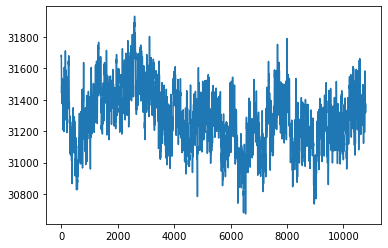

In [11]:
plt.plot(equilibration['grp_nrgs'])


# initial estimate of parameters:

In [12]:
#if doing total boost as well:
Vmax, Vmin, Vavg, Vstd = get_statistics(equilibration['tot_nrgs'],0)
E,k = calc_parameters(Vmax, Vmin, Vavg, Vstd, sigma_0=SIGMA0*5)
print('Etot:',E)
print('ktot:',k)
sim.integrator.setEtot(E)
sim.integrator.setKtot(k)

#for dihedral boost:
Vmax, Vmin, Vavg, Vstd = get_statistics(equilibration['grp_nrgs'], 0)
E,k = calc_parameters(Vmax, Vmin, Vavg, Vstd, sigma_0=SIGMA0*7)
print('Egrp:',E)
print('kgrp:',k)
sim.integrator.setEgrp(E)
sim.integrator.setKgrp(k)

Etot: -416469.0376032861
ktot: 9.462818474970943e-06
Egrp: 31932.34375
kgrp: 0.0001576235666710725


# Iteratively update parameters:

In [13]:
equilibration2 = dict()
equilibration2['grp_nrgs'] = list()
equilibration2['tot_nrgs'] = list()

equilibration2['grp_boosts'] = list()
equilibration2['tot_boosts'] = list()

ks = list()
k_0s = list()
vmaxs = list()

gks = list()
gk_0s = list()
gvmaxs = list()

num_steps = 5
steps_per_iter = 5



In [15]:

while num_steps / 500000 < 10:
    sim.step(steps_per_iter)
    report(sim, equilibration2, record_boost=True)
    num_steps+=steps_per_iter
    print(num_steps, end='\r')
    
    if (num_steps) % (2500)==0: #5 picoseconds:
        Vmax, Vmin, Vavg, Vstd = get_statistics(equilibration2['tot_nrgs'], equilibration2['tot_boosts'])
        E,k,k_0 = calc_parameters(Vmax, Vmin, Vavg, Vstd, sigma_0 = SIGMA0*5,verbose=True)
        sim.integrator.setEtot(E)
        sim.integrator.setKtot(k)
    
        ks.append(k)
        k_0s.append(k_0)
        vmaxs.append(E)
        print(np.around(E,2), k, k_0)

        #larger SIGMA0 for dihedrals group, i.e. below calculates up to an StdDev of 6kT :
        Vmax, Vmin, Vavg, Vstd = get_statistics(equilibration2['grp_nrgs'], equilibration2['grp_boosts'])
        E,k,k_0 = calc_parameters(Vmax, Vmin, Vavg, Vstd, sigma_0 = SIGMA0*7, verbose=True)
        sim.integrator.setEgrp(E)
        sim.integrator.setKgrp(k)
    
        gks.append(k)
        gk_0s.append(k_0)
        gvmaxs.append(E)
        print('\t',E, k, k_0)

-414653.88 1.3424166510362146e-05 0.045727233915511034
	 32228.443359375 0.0003328408554131209 0.3188394380091856
-414287.98 1.1208160055071607e-05 0.04227990514173325
	 32298.28515625 0.00029751593497915604 0.3057795573956062
-414010.76 9.456828151627994e-06 0.038295065421330335
	 32310.71875 0.00030779964507377455 0.32017595733662146
-414010.76 1.0039681896097422e-05 0.04065530946062607
	 32322.42578125 0.000322851385370574 0.33961254413738634
-414010.76 1.0659866827580854e-05 0.04316672471991602
	 32334.279296875 0.0003314977829840369 0.3526372424468244
-414010.76 1.130833248739579e-05 0.045792661711466835
	 32334.279296875 0.0003537144585747474 0.3762706651084205
-413903.63 1.1084264618217366e-05 0.046072709256444716
	 32361.6171875 0.00034426544370458567 0.3756305820000752
-413709.6 1.0113686170857777e-05 0.0440007867535873
	 32380.45703125 0.000340324211913147 0.37774192970325104
-413709.6 1.0422483391657592e-05 0.04534424555119805
	 32428.4453125 0.0003091316109654924 0.35795448

-412379.19 9.47287761863999e-06 0.053815649016387655
	 32794.48828125 0.00024394761746349226 0.3717709288585093
-412379.19 9.514747824543776e-06 0.054053514678320015
	 32794.48828125 0.0002443228360524384 0.3723427539281203
-412379.19 9.56170418183055e-06 0.05432027489042924
	 32794.48828125 0.0002452739620729366 0.3737922495525448
-412379.19 9.610076918111945e-06 0.05459508158618549
	 32794.48828125 0.00024602650991164063 0.3749391162935054
-412379.19 9.650129064524876e-06 0.05482261880776534
	 32794.48828125 0.0002469174175375696 0.37629684037813727
-412379.19 9.676567208221137e-06 0.05497281454754806
	 32794.48828125 0.0002477551192366496 0.37757347977314965
-412379.19 9.714937382967789e-06 0.05519079644702917
	 32794.48828125 0.00024838089418884214 0.37852714735823206
-412379.19 9.75994689453514e-06 0.05544649658107728
	 32794.48828125 0.00024894590529619194 0.37938821214902163
-412379.19 9.801293655875427e-06 0.05568138854166536
	 32794.48828125 0.0002497323028232291 0.38058666508

-411944.6 9.154597109281323e-06 0.05598602035988203
	 32825.3515625 0.00027456960587959786 0.4269123003930932
-411944.6 9.173172750071997e-06 0.056099621886097774
	 32825.3515625 0.00027530213861207755 0.428051272905853
-411944.6 9.19493997916487e-06 0.05623274194770444
	 32825.3515625 0.00027595095379221075 0.42906007786878136
-411944.6 9.207316731269997e-06 0.056308433437682125
	 32825.3515625 0.0002763995994146196 0.42975765083615425
-411944.6 9.225594824476777e-06 0.05642021527648933
	 32825.3515625 0.0002770609201204399 0.43078589991315924
-411944.6 9.24538882534297e-06 0.05654126782771243
	 32825.3515625 0.000277824713563697 0.43197347788575186
-411944.6 9.260143387537655e-06 0.056631501096262866
	 32825.3515625 0.0002785994080105191 0.4331780051943558
-411944.6 9.277486766373402e-06 0.05673756657888502
	 32825.3515625 0.00027937838552323323 0.43438919199284326
-411944.6 9.289256648921965e-06 0.05680954668637978
	 32825.3515625 0.00028008030342817244 0.4354805632920253
-411944.6 

-411890.19 1.0004280207721839e-05 0.06172665311986719
	 32846.0859375 0.0003020124854809375 0.4758436768544558
-411890.19 1.001662724486054e-05 0.06180283464044581
	 32846.0859375 0.00030241305389438897 0.47647480290338373
-411890.19 1.0027432797851176e-05 0.06186950516619802
	 32846.0859375 0.0003028761868009999 0.4772045040771716
-411890.19 1.0042944072967459e-05 0.061965210112348026
	 32846.0859375 0.0003033789336030735 0.47799661996087284
-411890.19 1.0056367365539203e-05 0.06204803215522354
	 32846.0859375 0.0003038652942358772 0.47876291818666317
-411890.19 1.0069971950931371e-05 0.06213197277922703
	 32846.0859375 0.0003042391492233424 0.47935195519803875
-411890.19 1.0079654377831908e-05 0.062191713589584044
	 32846.0859375 0.0003046422686313758 0.4799871005332541
-411890.19 1.008268053284031e-05 0.062210385039864535
	 32846.0859375 0.0003050138358336566 0.48057253296479835
-411890.19 1.009474983809257e-05 0.06228485294792343
	 32846.0859375 0.0003054984265545725 0.481336042559

KeyboardInterrupt: 

In [ ]:
while num_steps / 500000 < 20:
    sim.step(steps_per_iter)
    report(sim, equilibration2, record_boost=True)
    num_steps+=steps_per_iter
    print(num_steps, end='\r')
    
    if (num_steps) % (2500)==0: #5 picoseconds:
        Vmax, Vmin, Vavg, Vstd = get_statistics(equilibration2['tot_nrgs'], equilibration2['tot_boosts'])
        E,k,k_0 = calc_parameters(Vmax, Vmin, Vavg, Vstd, sigma_0 = SIGMA0*5,verbose=True)
        sim.integrator.setEtot(E)
        sim.integrator.setKtot(k)
    
        ks.append(k)
        k_0s.append(k_0)
        vmaxs.append(E)
        print(np.around(E,2), k, k_0)

        #larger SIGMA0 for dihedrals group, i.e. below calculates up to an StdDev of 6kT :
        Vmax, Vmin, Vavg, Vstd = get_statistics(equilibration2['grp_nrgs'], equilibration2['grp_boosts'])
        E,k,k_0 = calc_parameters(Vmax, Vmin, Vavg, Vstd, sigma_0 = SIGMA0*7, verbose=True)
        sim.integrator.setEgrp(E)
        sim.integrator.setKgrp(k)
    
        gks.append(k)
        gk_0s.append(k_0)
        gvmaxs.append(E)
        print('\t',E, k, k_0)

-411434.19 1.0807989553114458e-05 0.0716140026384158
	 33063.44140625 0.0002525978381484522 0.4528906573082083
-411434.19 1.0810748209898054e-05 0.07163228156561202
	 33063.44140625 0.0002527050801146446 0.453082934822996
-411434.19 1.0814340739303958e-05 0.0716560857531613
	 33063.44140625 0.00025278809862413777 0.45323178133573216
-411434.19 1.0815287152283665e-05 0.07166235670866998
	 33063.44140625 0.0002528952266779519 0.4534238546134121
-411434.19 1.0814023034151684e-05 0.07165398063106608
	 33063.44140625 0.0002529747550149278 0.45356644348539793
-411434.19 1.081807273361281e-05 0.07168081403856233
	 33063.44140625 0.0002530708789006021 0.45373878704180026
-411434.19 1.0822113009687683e-05 0.0717075850064712
	 33063.44140625 0.0002531866560843381 0.4539463676182131
-411434.19 1.0826933695509241e-05 0.07173952698841404
	 33063.44140625 0.00025328882526612687 0.4541295499773185
-411434.19 1.0832077865303429e-05 0.07177361238305688
	 33063.44140625 0.000253335952545701 0.4542140459

-411367.26 1.0654176654350677e-05 0.07130799856591592
	 33063.44140625 0.00025816957155542255 0.46288039444739126
-411367.26 1.0655643297185409e-05 0.07131781475054931
	 33063.44140625 0.00025824813239673234 0.46302124866578154
-411367.26 1.0660102753820384e-05 0.07134766172396154
	 33063.44140625 0.00025835854653394417 0.4632192136663711
-411367.26 1.066407041531636e-05 0.07137421713123926
	 33063.44140625 0.0002584422000577735 0.4633691987164053
-411367.26 1.0667168800640722e-05 0.07139495450620817
	 33063.44140625 0.00025853351728786 0.4635329242679008
-411367.26 1.0670298382396744e-05 0.071415900677706
	 33063.44140625 0.0002586325599331979 0.4637105009608663
-411347.16 1.0573778677712943e-05 0.07098236483567263
	 33063.44140625 0.00025870660566920233 0.46384325990407704
-411347.16 1.057728763982408e-05 0.07100592069364535
	 33063.44140625 0.0002588044435019841 0.4640186764504852
-411347.16 1.0579928555628365e-05 0.07102364930844181
	 33063.44140625 0.0002589019713995071 0.46419353

-411205.13 1.010444203404932e-05 0.06926682835454669
	 33063.44140625 0.0002649845302986777 0.47509914963304434
-411205.13 1.0107889652394705e-05 0.06929046207794844
	 33063.44140625 0.0002650859093362872 0.47528091531764705
-411205.13 1.0110088644719094e-05 0.06930553636145396
	 33063.44140625 0.00026518866406484697 0.4754651475220875
-411205.13 1.0113366897459222e-05 0.06932800906891154
	 33063.44140625 0.00026529445910334915 0.4756548307944322
-411205.13 1.0114980930463683e-05 0.06933907340543817
	 33063.44140625 0.00026540893773223563 0.47586008315076345
-411205.13 1.011607330093474e-05 0.06934656169995888
	 33063.44140625 0.00026548378522306594 0.4759942795855725
-411205.13 1.011573478545683e-05 0.06934424114693628
	 33063.44140625 0.000265551022044358 0.4761148306101318
-411205.13 1.0117105295194572e-05 0.06935363611030412
	 33063.44140625 0.00026564444635705293 0.47628233401671327
-411205.13 1.0119406947876622e-05 0.06936941413948398
	 33063.44140625 0.00026573235226179625 0.476

-411205.13 1.0299275801079407e-05 0.07060243076119778
	 33120.5078125 0.00024184094889633515 0.44740528401103175
-411205.13 1.0302832745875006e-05 0.07062681392691768
	 33120.5078125 0.00024191720299286971 0.4475463539409702
-411205.13 1.0303237806921012e-05 0.07062959065559328
	 33120.5078125 0.00024197862836448412 0.4476599907587136
-411205.13 1.0306729464162198e-05 0.07065352626945332
	 33120.5078125 0.00024206407894443316 0.4478180741650411
-411205.13 1.030951690097938e-05 0.07067263439110064
	 33120.5078125 0.00024215341910538754 0.4479833532886461
-411205.13 1.0312709643798144e-05 0.0706945209206153
	 33120.5078125 0.00024221949505418767 0.4481055936651172
-411205.13 1.031486705240016e-05 0.07070931014408978
	 33120.5078125 0.00024228490800400307 0.448226607494759
-411205.13 1.0318616872329346e-05 0.07073501548561385
	 33120.5078125 0.00024234068728788287 0.44832979906119996
-411205.13 1.0322691212871105e-05 0.07076294544414229
	 33120.5078125 0.0002424117479526315 0.448461261152

-411205.13 1.0486346943890298e-05 0.07188481970415043
	 33120.5078125 0.00024655023149986713 0.4561174476472428
-411205.13 1.04873695492699e-05 0.07189182975290569
	 33120.5078125 0.00024660512056363763 0.456218992308217
-411205.13 1.0490053765349604e-05 0.07191023028742634
	 33120.5078125 0.00024668213450221044 0.4563614679444449
-411205.13 1.0491485127578652e-05 0.07192004239991098
	 33120.5078125 0.0002467261112415154 0.4564428248264304
-411205.13 1.0494749176846544e-05 0.07194241774133191
	 33120.5078125 0.00024681235437393434 0.4566023744532822
-411205.13 1.0498069278363836e-05 0.07196517732579417
	 33120.5078125 0.00024687742097304245 0.4567227475347907
-411205.13 1.0501168277781529e-05 0.07198642123614694
	 33120.5078125 0.0002469265514492877 0.456813638820069
-411205.13 1.0503561147983688e-05 0.07200282456935517
	 33120.5078125 0.00024696789712663606 0.45689012824256375
-411205.13 1.0506041297717513e-05 0.07201982621133872
	 33120.5078125 0.00024702890990010626 0.45700300175454

-411205.13 1.0643912127979493e-05 0.07296494273560347
	 33120.5078125 0.0002518206915826079 0.4658677885260251
-411205.13 1.0644146243396653e-05 0.07296654761713586
	 33120.5078125 0.00025188214811202366 0.46598148298564035
-411205.13 1.064572976520788e-05 0.07297740279678105
	 33120.5078125 0.00025194719323537814 0.46610181633704645
-411205.13 1.0648261924724647e-05 0.072994760970347
	 33120.5078125 0.0002519971647487519 0.46619426353937304
-411205.13 1.064802196573403e-05 0.07299311603061068
	 33120.5078125 0.00025206549349572935 0.46632067158808055
-411205.13 1.0650616958374125e-05 0.0730109049306981
	 33120.5078125 0.0002521349681021325 0.46644919947449187
-411205.13 1.0652249651051568e-05 0.0730220971809048
	 33120.5078125 0.0002522159475136835 0.46659901122799907
-411205.13 1.0655280130525466e-05 0.07304287138108756
	 33120.5078125 0.00025229016479675774 0.4667363130570065
-411205.13 1.0658187431119184e-05 0.0730628011793408
	 33120.5078125 0.00025233982585487475 0.46682818591771

-411205.13 1.0803086050548248e-05 0.07405609380915477
	 33120.5078125 0.0002567536844547738 0.47499381572310595
-411205.13 1.0806596699353635e-05 0.07408015961183803
	 33120.5078125 0.00025682593113088027 0.47512747193306454
-411205.13 1.0810076498377104e-05 0.07410401393658499
	 33120.5078125 0.0002569061922488788 0.47527595484489993
-411205.13 1.0812239595970108e-05 0.07411884215858713
	 33120.5078125 0.0002569835038848831 0.4754189812207958
-411205.13 1.0815331126102509e-05 0.07414003486634005
	 33120.5078125 0.00025704875329045097 0.4755396924938985
-411205.13 1.0817428079841064e-05 0.07415440966647117
	 33120.5078125 0.0002571284399926334 0.4756871127375939
-411205.13 1.0820538490340207e-05 0.07417573180077906
	 33120.5078125 0.00025719438722523737 0.47580911498935313
-411205.13 1.0821271099838425e-05 0.07418075390256292
	 33120.5078125 0.00025727313430695274 0.4759547969370162
-411205.13 1.08242769729413e-05 0.07420135942393369
	 33120.5078125 0.0002573635975197051 0.476122153704

	 33121.69921875 0.00026155056711225363 0.48417965226870074
-411205.13 1.0974463017796477e-05 0.07523089781459165
	 33121.69921875 0.00026163285395140284 0.4843319807977704
-411205.13 1.097741937241353e-05 0.0752511638824383
	 33121.69921875 0.00026172155165273724 0.4844961770473266
-411205.13 1.0980241603522863e-05 0.0752705105219824
	 33121.69921875 0.0002618046151131247 0.48464994324944444
-411205.13 1.0983330027910607e-05 0.07529168193958577
	 33121.69921875 0.0002618801129991501 0.48478970414006844
-411205.13 1.0986520726565421e-05 0.0753135544561789
	 33121.69921875 0.0002619659301501973 0.484948567945303
-411205.13 1.0989211809607254e-05 0.07533200206432177
	 33121.69921875 0.00026203479532505166 0.4850760504309369
-411205.13 1.0990416167569574e-05 0.07534025804282829
	 33121.69921875 0.00026211690443951873 0.4852280499579487
-411205.13 1.0992875962307827e-05 0.07535712014954807
	 33121.69921875 0.0002621781976904611 0.48534151537786874
-411205.13 1.0995301106195423e-05 0.075373

-411205.13 1.114580053500237e-05 0.07640543138655957
	 33121.69921875 0.0002662035097526433 0.49279313062787095
-411205.13 1.1148874272047826e-05 0.07642650212115502
	 33121.69921875 0.00026626833069807207 0.49291312647863095
-411205.13 1.1151138947332964e-05 0.07644202666706522
	 33121.69921875 0.0002663367939622522 0.4930398649514621
-411205.13 1.1153963255285673e-05 0.07646138754355117
	 33121.69921875 0.0002664037383498303 0.49316379169594127
-411205.13 1.115659102456087e-05 0.07647940113032094
	 33121.69921875 0.0002664744885270166 0.4932947636780181
-411205.13 1.1158996922104212e-05 0.07649589376708521
	 33121.69921875 0.0002665523398913258 0.49343888130282787
-411205.13 1.1160679878458634e-05 0.07650743057916619
	 33121.69921875 0.000266607552632673 0.49354109054749307
-411205.13 1.1162058405115072e-05 0.07651688049920848
	 33121.69921875 0.00026668188521450224 0.4936786942392751
-411205.13 1.1164870826925857e-05 0.07653615989515847
	 33121.69921875 0.00026675750871098757 0.4938

-411205.13 1.1309440825265076e-05 0.07752719979884
	 33121.69921875 0.0002710774402423991 0.5018156993638774
-411205.13 1.131176438934441e-05 0.07754312803255263
	 33121.69921875 0.0002711487900585816 0.5019477813913419
-411205.13 1.1314555550969147e-05 0.07756226168807946
	 33121.69921875 0.00027121700307085805 0.5020740566004873
-411205.13 1.1317446689702832e-05 0.07758208069537749
	 33121.69921875 0.0002712761850124562 0.5021836135868091
-411205.13 1.1320121505491488e-05 0.07760041679008599
	 33121.69921875 0.0002713384776290431 0.5022989290218738
-411205.13 1.1322641149606858e-05 0.07761768916948762
	 33121.69921875 0.00027139578279114767 0.5024050117337843
-411205.13 1.1325282798722778e-05 0.07763579790377188
	 33121.69921875 0.0002714666953906319 0.5025362843903065
-411205.13 1.1327969511808412e-05 0.07765421555548521
	 33121.69921875 0.0002715364666970247 0.5026654442970908
-411205.13 1.1330316529472622e-05 0.0776703045655606
	 33121.69921875 0.00027160484850410844 0.50279203197

	 33121.69921875 0.00027537461123006314 0.5097705769904793
-411205.13 1.146637392595509e-05 0.07860298984365514
	 33121.69921875 0.00027544561699720027 0.5099020221179784
-411205.13 1.1468331552158467e-05 0.0786164095414232
	 33121.69921875 0.0002755035409580728 0.510009250343644
-411205.13 1.1469715359418264e-05 0.07862589566046045
	 33121.69921875 0.0002755558370105284 0.5101060602445842
-411205.13 1.1471042249487084e-05 0.0786349916072067
	 33121.69921875 0.0002755989903222879 0.510185945200341
-411205.13 1.1472048434518167e-05 0.07864188909304572
	 33121.69921875 0.0002756506481959129 0.5102815737113585
-411205.13 1.1474884027216883e-05 0.07866132732744634
	 33121.69921875 0.00027571170644946646 0.5103946041065899
-411205.13 1.1477022780684403e-05 0.07867598866835247
	 33121.69921875 0.0002757670415915477 0.5104970399382034
-411205.13 1.1479561856353828e-05 0.078693394252746
	 33121.69921875 0.0002758324393970506 0.5106181036662508
-411205.13 1.1481134494182353e-05 0.07870417482174

-411205.13 1.1582327848714975e-05 0.07939786406212068
	 33121.69921875 0.00027921327180455347 0.5168766649743628
-411205.13 1.158399832591104e-05 0.07940931532848652
	 33121.69921875 0.0002792871979430962 0.5170135162626179
-411205.13 1.1586521149735219e-05 0.0794266095050684
	 33121.69921875 0.0002793432888076193 0.5171173510796482
-411205.13 1.1588444474659826e-05 0.07943979406458923
	 33121.69921875 0.00027939401304032796 0.5172112512444448
-411205.13 1.1589925531122391e-05 0.07944994683536373
	 33121.69921875 0.0002794563571789893 0.5173266620566305
-411205.13 1.1592102541053773e-05 0.07946487042765463
	 33121.69921875 0.00027949513869356715 0.5173984539875371
-411205.13 1.159462491865052e-05 0.07948216154530867
	 33121.69921875 0.00027956074541618487 0.5175199044607449
-411205.13 1.1595803315123283e-05 0.07949023955554788
	 33121.69921875 0.00027962364968298124 0.5176363521762286
-411205.13 1.1597524131991143e-05 0.07950203590473905
	 33121.69921875 0.0002796689893545083 0.5177202

-411205.13 1.1708215076121091e-05 0.08026083194727315
	 33121.69921875 0.0002834750322394593 0.5247659909590379
-411205.13 1.17095000863926e-05 0.08026964080436892
	 33121.69921875 0.00028353568564516983 0.5248782719042107
-411205.13 1.171188227215246e-05 0.08028597089479655
	 33121.69921875 0.0002835909223445647 0.5249805254997612
-411205.13 1.171373319034224e-05 0.08029865909985705
	 33121.69921875 0.00028363775806111306 0.525067227284439
-411205.13 1.1715566921484333e-05 0.08031122948621186
	 33121.69921875 0.00028369207283349064 0.525167774218415
-411205.13 1.171773727661343e-05 0.0803261074592547
	 33121.69921875 0.0002837342296451792 0.5252458144637467
-411205.13 1.171945061154372e-05 0.08033785251911356
	 33121.69921875 0.00028377750994855596 0.5253259345050467
-411205.13 1.17219541843305e-05 0.08035501472816088
	 33121.69921875 0.00028380783912124137 0.5253820795497566
-411205.13 1.1723882098434833e-05 0.0803682307469076
	 33121.69921875 0.0002838434084042257 0.5254479250314046

	 33121.69921875 0.0002875316129085276 0.5322754903244377
-411205.13 1.1840104566576047e-05 0.08116494586730234
	 33121.69921875 0.000287575279356674 0.5323563251928639
-411205.13 1.1841854059779815e-05 0.08117693879526852
	 33121.69921875 0.0002876273643693202 0.5324527444191339
-411205.13 1.1843405848813596e-05 0.08118757644396632
	 33121.69921875 0.00028767242632777483 0.5325361626415297
-411205.13 1.1844319959558843e-05 0.08119384275257344
	 33121.69921875 0.0002877139176235356 0.5326129708907926
-411205.13 1.1846478647489761e-05 0.08120864074595872
	 33121.69921875 0.0002877618996051048 0.5327017946291919
-411205.13 1.1848869703820948e-05 0.08122503164492378
	 33121.69921875 0.00028780654518421823 0.5327844420545412
-411205.13 1.1851229444867572e-05 0.08124120787489145
	 33121.69921875 0.0002878668813590384 0.5328961357452343
-411205.13 1.1853454674432366e-05 0.08125646201696031
	 33121.69921875 0.0002879235100294006 0.5330009661427637
-411205.13 1.1855537084581173e-05 0.081270737

-411205.13 1.1963339549598703e-05 0.08200973238669068
	 33121.69921875 0.0002912380285912839 0.5391367679590222
-411205.13 1.196519812116212e-05 0.08202247305629264
	 33121.69921875 0.0002912825627411486 0.5392192091077211
-411205.13 1.1967359859641825e-05 0.082037291961455
	 33121.69921875 0.0002913170530847802 0.5392830572682147
-411205.13 1.1969465657403543e-05 0.08205172738813356
	 33121.69921875 0.000291348885736628 0.5393419855376986
-411205.13 1.1970700933098283e-05 0.08206019531038297
	 33121.69921875 0.0002913858373407176 0.5394103899576026
-411205.13 1.1973032010117039e-05 0.08207617504594832
	 33121.69921875 0.0002914263530779373 0.5394853922631797
-411205.13 1.1974826463314883e-05 0.08208847617858152
	 33121.69921875 0.00029148464535714024 0.5395933023158554
-411205.13 1.1975527056789422e-05 0.08209327880774042
	 33121.69921875 0.00029151867319246455 0.5396562942858468
-411205.13 1.1976870411495653e-05 0.08210248762100712
	 33121.69921875 0.0002915634231089068 0.53973913485

	 33121.69921875 0.000294906066643658 0.5459270013288646
-411205.13 1.2076330114083346e-05 0.08278429252662398
	 33121.69921875 0.00029496404982057246 0.5460343391746428
-411205.13 1.2078316866660777e-05 0.08279791188821764
	 33121.69921875 0.0002950105286872057 0.5461203803625201
-411205.13 1.2079987507798221e-05 0.08280936427841587
	 33121.69921875 0.00029505891009367464 0.5462099435120825
-411205.13 1.2080794050873415e-05 0.0828148932012957
	 33121.69921875 0.00029510143110578473 0.5462886579613949
-411205.13 1.2081755754998933e-05 0.08282148576666108
	 33121.69921875 0.0002951276468909672 0.5463371883465274
-411205.13 1.2082183726385927e-05 0.08282441954771537
	 33121.69921875 0.00029517008626349096 0.5464157516654984
-411205.13 1.2083519534758826e-05 0.0828335766302112
	 33121.69921875 0.0002952275458745621 0.5465221202917073
-411205.13 1.2084201833523268e-05 0.08283825384754233
	 33121.69921875 0.00029528569956507807 0.5466297737904668
-411205.13 1.2086219107891741e-05 0.08285208

-411156.13 1.1877018777494747e-05 0.08199996991158584
	 33121.69921875 0.00029834763664730103 0.5522979994345851
-411156.13 1.1877709897910226e-05 0.08200474146700192
	 33121.69921875 0.00029839436560033744 0.5523845035797753
-411156.13 1.1879164875292637e-05 0.08201478675730708
	 33121.69921875 0.0002984347121878885 0.5524591927572693
-411156.13 1.1879931315509676e-05 0.08202007832717942
	 33121.69921875 0.00029845856296786507 0.5525033450696993
-411156.13 1.188171347645405e-05 0.08203238252123299
	 33121.69921875 0.00029850748920039205 0.5525939167955162
-411156.13 1.1883847243005441e-05 0.08204711423095665
	 33121.69921875 0.0002985545906357509 0.5526811104760545
-411156.13 1.1885630620051516e-05 0.08205942682108207
	 33121.69921875 0.0002985866570595663 0.5527404715017401
-411156.13 1.1887686730367027e-05 0.08207362238540383
	 33121.69921875 0.00029862823782599685 0.5528174453781637
-411156.13 1.1889860555685311e-05 0.08208863066433576
	 33121.69921875 0.00029867579385828145 0.5529

-410902.01 1.0648011650742185e-05 0.07622072385207629
	 33121.69921875 0.00030174865486565553 0.5585939285029234
-410902.01 1.0649511478163765e-05 0.07623145993459345
	 33121.69921875 0.0003017859318255729 0.5586629352181055
-410902.01 1.065005855749506e-05 0.07623537604438028
	 33121.69921875 0.0003018377024244825 0.5587587724049813
-410902.01 1.064798283940382e-05 0.07622051761441076
	 33121.69921875 0.00030187163626262326 0.5588215903683775
-410902.01 1.064782317975056e-05 0.07621937473677871
	 33121.69921875 0.00030193036055673275 0.5589303001624933
-410902.01 1.0647039590681822e-05 0.07621376564017168
	 33121.69921875 0.00030198248605431535 0.5590267943340508
-410902.01 1.0647129740968021e-05 0.07621441095502435
	 33121.69921875 0.00030203758384907077 0.5591287907907971
-410902.01 1.064770351215097e-05 0.07621851813074168
	 33121.69921875 0.00030209760963409004 0.5592399098911633
-410902.01 1.0647005954038438e-05 0.0762135248619503
	 33121.69921875 0.0003021503579671906 0.55933755

	 33121.69921875 0.0003050947026646389 0.5647880969104837
-410902.01 1.0710357617072425e-05 0.07666700949101217
	 33121.69921875 0.00030513353575760074 0.5648599843227512
-410902.01 1.071170212273684e-05 0.07667663374747677
	 33121.69921875 0.0003051830272444914 0.5649516024414865
-410902.01 1.0713331944652738e-05 0.07668830035813183
	 33121.69921875 0.0003052339203052921 0.5650458151390672
-410902.01 1.071477025847239e-05 0.07669859611325083
	 33121.69921875 0.00030528666745843557 0.5651434601128447
-410902.01 1.0715980892733931e-05 0.07670726208984453
	 33121.69921875 0.00030533253116344673 0.5652283625200129
-410902.01 1.0717263311174176e-05 0.07671644191280143
	 33121.69921875 0.0003053854972347007 0.5653264127526885
-410902.01 1.0718776456808645e-05 0.07672727332990875
	 33121.69921875 0.0003054354140837399 0.5654188182973485
-410902.01 1.0719980169057776e-05 0.07673588975727075
	 33121.69921875 0.00030548201313929243 0.565505081977686
-410902.01 1.0721130163021964e-05 0.076744121

-410896.44 1.0751674204386273e-05 0.07702256856630398
	 33122.49609375 0.0003078192731017216 0.5700770864612819
-410896.44 1.0751558516444955e-05 0.07702173980399002
	 33122.49609375 0.0003078505843172199 0.570135074404418
-410896.44 1.0750591579307952e-05 0.07701481288446863
	 33122.49609375 0.00030787864726907724 0.5701870466076888
-410896.44 1.0751128180620006e-05 0.07701865697521809
	 33122.49609375 0.0003079001080177532 0.5702267916209078
-410896.44 1.0751633594106198e-05 0.07702227764341865
	 33138.03515625 0.00029728879071209784 0.5551943661074427
-410896.44 1.0751911835368946e-05 0.07702427090105747
	 33138.03515625 0.0002973094198208952 0.5552328914919843
-410896.44 1.075277468842336e-05 0.07703045218569118
	 33138.03515625 0.00029735190205838215 0.5553122281492996
-410896.44 1.0754049188697151e-05 0.0770395824181424
	 33138.03515625 0.0002973835145608339 0.5553712653004068
-410896.44 1.0755318509088553e-05 0.0770486755430847
	 33138.03515625 0.0002974163384845145 0.5554325648

-410896.44 1.0811828683838669e-05 0.07745350168705481
	 33162.3046875 0.000283997970597519 0.5372659196542162
-410896.44 1.081210815526313e-05 0.07745550375729462
	 33162.3046875 0.00028403807662120083 0.5373417920263031
-410896.44 1.0813504694530676e-05 0.07746550824956674
	 33162.3046875 0.0002840865985009041 0.5374335854721057
-410896.44 1.0814392774204186e-05 0.07747187025200888
	 33162.3046875 0.000284130087480136 0.5375158577023358
-410896.44 1.0815000865573256e-05 0.07747622648139961
	 33162.3046875 0.00028416189564727873 0.5375760322315287
-410896.44 1.0816369257288623e-05 0.07748602933095763
	 33162.3046875 0.0002842020964922513 0.5376520839860522
-410896.44 1.08163027634699e-05 0.07748555298424041
	 33162.3046875 0.0002842307568601041 0.5377063035245218
-410896.44 1.0817644623133298e-05 0.0774951657641634
	 33162.3046875 0.00028427349780180193 0.5377871606211406
-410896.44 1.0818603458588735e-05 0.07750203464506569
	 33162.3046875 0.00028431275529363476 0.5378614277449814
-41

-410896.44 1.0888873412530664e-05 0.07800543274314378
	 33162.3046875 0.0002865274984234784 0.5420512675595046
-410896.44 1.088998042350227e-05 0.0780133631200175
	 33162.3046875 0.000286562290359393 0.5421170867673194
-410896.44 1.0890778645632792e-05 0.07801908140329232
	 33162.3046875 0.00028659302241489744 0.5421752255139756
-410896.44 1.0891828873141672e-05 0.07802660499624865
	 33162.3046875 0.0002866143933889924 0.5422156550143233
-410896.44 1.0892930118610162e-05 0.07803449407035866
	 33162.3046875 0.00028664505078736474 0.5422736525249959
-410896.44 1.0894245004260707e-05 0.07804391361453855
	 33162.3046875 0.0002866712654859073 0.5423232453586746
-410896.44 1.0895522948583027e-05 0.0780530685193765
	 33162.3046875 0.00028670816933423353 0.5423930598716729
-410896.44 1.0896799683688897e-05 0.07806221476166059
	 33162.3046875 0.00028674083962097334 0.5424548653543448
-410896.44 1.0898221774183771e-05 0.07807240229716127
	 33162.3046875 0.0002867793927438551 0.5425277999565782
-

-410706.38 1.0081864049761225e-05 0.07414038400474143
	 33162.3046875 0.0002890702422270764 0.5468616173842265
-410706.38 1.0082360148960748e-05 0.07414403223734758
	 33162.3046875 0.00028910900874889523 0.5469349556934862
-410706.38 1.008332597910998e-05 0.07415113479475105
	 33162.3046875 0.0002891412257147142 0.5469959035859403
-410706.38 1.0084672997095552e-05 0.07416104054533633
	 33162.3046875 0.0002891817140492507 0.5470724992117622
-410706.38 1.0085510397526344e-05 0.07416719865153557
	 33162.3046875 0.0002892256467194161 0.5471556108142486
-410706.38 1.0086375311247647e-05 0.07417355908598616
	 33162.3046875 0.0002892707859123779 0.5472410049104389
-410706.38 1.0086599909605092e-05 0.07417521074567782
	 33162.3046875 0.00028931473689249097 0.5473241511515916
-410706.38 1.0087333134528384e-05 0.07418060276218454
	 33162.3046875 0.0002893640473423256 0.5474174364103673
-410706.38 1.008783654155442e-05 0.07418430473535505
	 33162.3046875 0.00028940767736958614 0.5474999754745421


-410706.38 1.0143876936785482e-05 0.07459641666244524
	 33226.6640625 0.0002559243596889064 0.5006275368311708
-410706.38 1.0144766848510876e-05 0.07460296092814109
	 33226.6640625 0.00025593750865439104 0.5006532582365518
-410706.38 1.0145079177337758e-05 0.07460525774339732
	 33226.6640625 0.0002559348312940232 0.500648020906554
-410706.38 1.0146047237648029e-05 0.07461237670104136
	 33226.6640625 0.0002559620625346661 0.5007012894150481
-410706.38 1.0146749895812602e-05 0.07461754393458948
	 33226.6640625 0.00025596760653382014 0.5007121343328357
-410706.38 1.0147951231006189e-05 0.07462637835768142
	 33226.6640625 0.0002559878199389578 0.5007516748722254
-410706.38 1.0149259270021284e-05 0.07463599746327475
	 33226.6640625 0.0002560110834302245 0.5007971818507133
-410706.38 1.0150350344384989e-05 0.0746440210462058
	 33226.6640625 0.00025602449865216387 0.5008234240948034
-410706.38 1.0151602647590922e-05 0.07465323027974832
	 33226.6640625 0.0002560361661423937 0.5008462475059936


-410706.38 1.0185678549556153e-05 0.07490381890547672
	 33226.6640625 0.0002576747678962908 0.5040516053738336
-410706.38 1.0186234862910335e-05 0.0749079099431561
	 33226.6640625 0.0002576966429842913 0.5040943964213016
-410706.38 1.018707235430052e-05 0.07491406871825589
	 33226.6640625 0.00025772199734519605 0.5041439934634241
-410706.38 1.0187121756010573e-05 0.07491443201037486
	 33226.6640625 0.00025773896823784773 0.5041771911480695
-410706.38 1.0188158328766752e-05 0.07492205479737263
	 33226.6640625 0.00025775465366688674 0.5042078742675408
-410706.38 1.0189042973590102e-05 0.07492856033112981
	 33226.6640625 0.00025776830219641743 0.5042345728972789
-410706.38 1.0189863499449231e-05 0.07493459434448105
	 33226.6640625 0.0002578009512682298 0.504298439519515
-410706.38 1.0190351470927089e-05 0.07493818280714759
	 33226.6640625 0.0002578281612591361 0.5043516664602453
-410706.38 1.019085359495209e-05 0.07494187534533775
	 33226.6640625 0.00025784974382103107 0.504393885281514
-

-410706.38 1.0241167540111884e-05 0.07531187589251126
	 33226.6640625 0.0002594200250606499 0.50746559768153
-410706.38 1.0241858300883597e-05 0.07531695563457258
	 33226.6640625 0.0002594491121641254 0.5075224965440853
-410706.38 1.0242167931168611e-05 0.07531923260519202
	 33226.6640625 0.00025947656717759305 0.5075762027867528
-410706.38 1.0242072414574236e-05 0.07531853019173447
	 33226.6640625 0.00025948916160755417 0.5076008394350847
-410706.38 1.0242862634843443e-05 0.07532434134271986
	 33226.6640625 0.0002594975450111375 0.5076172386660578
-410706.38 1.0243549088839889e-05 0.07532938941345825
	 33226.6640625 0.00025951439410502696 0.5076501980935307
-410706.38 1.0244766768648485e-05 0.07533834403218338
	 33226.6640625 0.0002595067427091728 0.5076352307826251
-410706.38 1.0245341281212205e-05 0.07534256890388165
	 33226.6640625 0.0002595275791961848 0.5076759901663027
-410706.38 1.0246091517886905e-05 0.07534808602203383
	 33226.6640625 0.0002595476638795803 0.5077152789061029


-410706.38 1.0285517624852768e-05 0.07563801918278998
	 33226.6640625 0.0002607504782367313 0.5100681693836552
-410706.38 1.0286185201902838e-05 0.07564292843554331
	 33226.6640625 0.00026077733941882065 0.5101207140005181
-410706.38 1.0286107325615078e-05 0.0756423557460237
	 33226.6640625 0.00026079765783973646 0.5101604599669738
-410706.38 1.0286909404566045e-05 0.07564825410382077
	 33226.6640625 0.00026081015470133154 0.5101849057565269
-410706.38 1.0285217646847951e-05 0.07563581319346496
	 33226.6640625 0.00026081647118959833 0.5101972617822146
-410706.38 1.0285737861638226e-05 0.07563963876819257
	 33226.6640625 0.0002608286585091403 0.5102211020597492
-410706.38 1.0285800487922202e-05 0.07564009931167141
	 33226.6640625 0.0002608427456103539 0.5102486586033711
-410706.38 1.0286028502546763e-05 0.0756417760940343
	 33226.6640625 0.0002608591839640172 0.5102808145595842
-410706.38 1.0286022788552747e-05 0.07564173407425419
	 33226.6640625 0.0002608560485911875 0.5102746812865394

-410706.38 1.029069349455067e-05 0.07567608168443322
	 33226.6640625 0.0002617344563036085 0.5119929823108631
-410706.38 1.029019042476275e-05 0.07567238219125681
	 33226.6640625 0.0002617449948935451 0.5120135974188897
-410706.38 1.0290575476946629e-05 0.0756752138022202
	 33226.6640625 0.000261761051121474 0.512045005878204
-410706.38 1.0290643790379142e-05 0.07567571616806189
	 33226.6640625 0.00026177404628291786 0.5120704264191493
-410706.38 1.0291000637554966e-05 0.0756783403639959
	 33226.6640625 0.000261789413022626 0.5121004861331154
-410706.38 1.0292071322424059e-05 0.07568621400590882
	 33226.6640625 0.0002618157544386396 0.512152014007334
-410706.38 1.029307044012111e-05 0.0756935613545102
	 33226.6640625 0.00026184624177638265 0.5122116519441737
-410706.38 1.0293518843522053e-05 0.07569685883999214
	 33226.6640625 0.000261872467870644 0.5122629542312507
-410706.38 1.0293942398998146e-05 0.07569997359788709
	 33226.6640625 0.0002618896052547515 0.5122964775988734
-410706.38

-410706.38 1.032853076215475e-05 0.07595433077964128
	 33226.6640625 0.0002637028150680026 0.5158433957729365
-410706.38 1.032967297785175e-05 0.07596273044759691
	 33226.6640625 0.0002637183128937524 0.5158737119114266
-410706.38 1.0330309185206225e-05 0.07596740901272481
	 33226.6640625 0.00026374350738326386 0.5159229962204357
-410706.38 1.0330522724455915e-05 0.07596897934554163
	 33226.6640625 0.0002637636701373626 0.5159624376785777
-410706.38 1.0330947963296529e-05 0.07597210648262473
	 33226.6640625 0.00026376547284009656 0.5159659640432834
-410706.38 1.0331426534511361e-05 0.07597562581729005
	 33226.6640625 0.0002637860164804038 0.5160061505736202
-410706.38 1.0332037670884933e-05 0.07598012001451313
	 33226.6640625 0.00026380303120080616 0.5160394339921086
-410706.38 1.0332520992487835e-05 0.07598367428275757
	 33226.6640625 0.00026382337413780114 0.516079227915798
-410706.38 1.0333446857876322e-05 0.07599048294582825
	 33226.6640625 0.000263835512354407 0.516102972140413
-4

-410706.38 1.0381350076828357e-05 0.0763427554056271
	 33226.6640625 0.00026541349569531166 0.5191897510389829
-410706.38 1.03823849908141e-05 0.07635036599429763
	 33226.6640625 0.0002654501293097256 0.5192614120413649
-410706.38 1.0383029243840819e-05 0.07635510372598707
	 33226.6640625 0.0002654724036860957 0.5193049841584942
-410706.38 1.0384081182110031e-05 0.07636283950846179
	 33226.6640625 0.00026549520167828874 0.5193495805489674
-410706.38 1.0384670801780904e-05 0.0763671754753623
	 33226.6640625 0.00026551417110151176 0.5193866876677848
-410706.38 1.0385286414649586e-05 0.07637170259200037
	 33226.6640625 0.0002655194837964378 0.519397080118812
-410706.38 1.0386174898796077e-05 0.07637823635951378
	 33226.6640625 0.00026554904977843085 0.5194549157416389
-410706.38 1.0387329071588572e-05 0.07638672395799964
	 33226.6640625 0.000265570888293566 0.5194976352469391
-410706.38 1.0388455787203472e-05 0.07639500964087936
	 33226.6640625 0.00026558361312323123 0.519522526977213
-41

-410706.38 1.043782675797518e-05 0.0767580757081894
	 33226.6640625 0.0002669989988523777 0.5222912398582765
-410706.38 1.0438746627085818e-05 0.07676484027561069
	 33226.6640625 0.00026701611374401623 0.5223247192271593
-410706.38 1.0439784691473455e-05 0.07677247403182295
	 33226.6640625 0.00026703977555244583 0.5223710053754786
-410706.38 1.0440673055203835e-05 0.07677900691381592
	 33226.6640625 0.00026705993268391967 0.5224104358348987
-410706.38 1.044112709744695e-05 0.07678234586642357
	 33226.6640625 0.0002670783898740684 0.5224465409467849
-410706.38 1.0442223525029973e-05 0.07679040881605645
	 33226.6640625 0.000267107621235642 0.5225037220004393
-410706.38 1.0443279735820316e-05 0.07679817601795477
	 33226.6640625 0.00026712250139333794 0.5225328298849096
-410706.38 1.0444278646656601e-05 0.07680552184533582
	 33226.6640625 0.00026713849354239965 0.5225641129960723
-410706.38 1.0445113642956383e-05 0.07681166227194768
	 33226.6640625 0.0002671604554928059 0.5226070739598089


-410706.38 1.0484973523695202e-05 0.07710478533428745
	 33226.6640625 0.0002688261702489991 0.5258654690436922
-410706.38 1.0486198174123876e-05 0.07711379121381581
	 33226.6640625 0.0002688539320061665 0.5259197753243673
-410706.38 1.0487042528820214e-05 0.07712000046054972
	 33226.6640625 0.00026888260411120113 0.5259758623859376
-410706.38 1.048705650231818e-05 0.07712010321937486
	 33226.6640625 0.00026890820308876927 0.5260259379359983
-410706.38 1.0487738076608716e-05 0.07712511540555182
	 33226.6640625 0.0002689358421767408 0.5260800042567982
-410706.38 1.0487714311938542e-05 0.07712494064404306
	 33226.6640625 0.0002689651168269337 0.5261372699896713
-410706.38 1.0488374551812426e-05 0.0771297959403993
	 33226.6640625 0.00026899655486739343 0.5261987676477187
-410706.38 1.048920545869616e-05 0.07713590629411249
	 33226.6640625 0.0002690306236178527 0.5262654113804452
-410706.38 1.0489980020086725e-05 0.0771416022922581
	 33226.6640625 0.00026905772942607755 0.5263184345237754
-

-410706.38 1.0531813624652802e-05 0.07744923979773556
	 33226.6640625 0.000270753297264481 0.5296352268428101
-410706.38 1.053258929723361e-05 0.077454943967393
	 33226.6640625 0.0002707836122978582 0.5296945277257236
-410706.38 1.0533318456329534e-05 0.07746030608446833
	 33226.6640625 0.0002708013003410342 0.5297291282674512
-410706.38 1.0534276720069486e-05 0.07746735299973193
	 33226.6640625 0.0002708222293354137 0.5297700686098138
-410706.38 1.0535229130595861e-05 0.07747435687141747
	 33226.6640625 0.00027084582846331333 0.5298162321453448
-410706.38 1.0536201164636705e-05 0.07748150505122808
	 33226.6640625 0.0002708721137664848 0.5298676502541859
-410706.38 1.0537198996244548e-05 0.07748884294213917
	 33226.6640625 0.0002708951549647286 0.5299127223932213
-410706.38 1.0538035954726553e-05 0.0774949977983191
	 33226.6640625 0.0002709229680914 0.5299671291605724
-410706.38 1.0538091540878384e-05 0.07749540656981431
	 33226.6640625 0.00027094590406717516 0.5300119954682232
-410706

-410706.38 1.0592412061758958e-05 0.07789487082141952
	 33226.6640625 0.000272363041414507 0.532784134784733
-410706.38 1.0593485686556989e-05 0.0779027660830904
	 33226.6640625 0.00027238284651040154 0.5328228766082407
-410706.38 1.0594279620074435e-05 0.07790860454069776
	 33226.6640625 0.0002724019139281043 0.532860175419381
-410706.38 1.0594142544780726e-05 0.07790759651134296
	 33226.6640625 0.0002724229082584721 0.532901243569018
-410706.38 1.0593918571090524e-05 0.07790594944535233
	 33226.6640625 0.00027244154857386987 0.5329377069021477
-410706.38 1.0594965295444613e-05 0.07791364688554556
	 33226.6640625 0.00027245698660669507 0.5329679060764514
-410706.38 1.0595547988048995e-05 0.0779179319119288
	 33226.6640625 0.0002724777011178548 0.533008426856541
-410706.38 1.0596193419253063e-05 0.07792267830774233
	 33226.6640625 0.00027249658385188784 0.5330453643979267
-410706.38 1.0595841354499783e-05 0.07792008928096376
	 33226.6640625 0.00027252327926469583 0.5330975847444971
-41

-410706.38 1.0643360308554768e-05 0.07826953591937817
	 33226.6640625 0.0002740980604402719 0.5361780997135882
-410706.38 1.0644208033212193e-05 0.07827576994825633
	 33226.6640625 0.0002741258700491861 0.5362324995996635
-410706.38 1.0645132026592066e-05 0.07828256484488094
	 33226.6640625 0.00027415425905043196 0.53628803286654
-410706.38 1.0645978437328446e-05 0.07828878921139802
	 33226.6640625 0.000274182869528043 0.5363439993753607
-410706.38 1.0646772828479744e-05 0.07829463103437008
	 33226.6640625 0.0002742137477266475 0.5364044018963555
-410706.38 1.0647013472890963e-05 0.0782964006941243
	 33226.6640625 0.00027424512220897254 0.5364657752248844
-410706.38 1.064795461800844e-05 0.07830332172183005
	 33226.6640625 0.0002742732553652939 0.5365208080196116
-410706.38 1.064782201148889e-05 0.07830234655511163
	 33226.6640625 0.0002742971283602128 0.5365675072812902
-410706.38 1.064866746007619e-05 0.07830856384614127
	 33226.6640625 0.0002743243015750494 0.5366206622823536
-41070

-410706.38 1.0696400822624251e-05 0.07865958720964662
	 33226.6640625 0.00027601919188229257 0.5399361292458955
-410706.38 1.069731509657397e-05 0.078666310631167
	 33226.6640625 0.00027604635312217013 0.5399892608220913
-410706.38 1.069823950692961e-05 0.0786731085941634
	 33226.6640625 0.00027607060995275573 0.54003671092556
-410706.38 1.0698753240377454e-05 0.0786768865061558
	 33226.6640625 0.0002760996821081679 0.5400935805473969
-410706.38 1.0699689650468718e-05 0.07868377271325099
	 33226.6640625 0.00027612903329494206 0.5401509959976326
-410706.38 1.0700406105371319e-05 0.0786890414057605
	 33226.6640625 0.0002761584232791153 0.5402084873415673
-410706.38 1.070140225541493e-05 0.07869636693072246
	 33226.6640625 0.0002761868425859354 0.5402640798908234
-410706.38 1.0702207601747432e-05 0.07870228931631047
	 33226.6640625 0.0002762068807921507 0.5403032777140875
-410706.38 1.0703197838962915e-05 0.07870957135929868
	 33226.6640625 0.00027622752870095393 0.5403436682096912
-41070

-410706.38 1.0745342095134047e-05 0.0790194933460166
	 33226.6640625 0.0002772753546455724 0.5423933774375262
-410706.38 1.0745966095520531e-05 0.07902408214309269
	 33226.6640625 0.00027729862639161 0.5424389005636199
-410706.38 1.0745919290476078e-05 0.07902373794642906
	 33226.6640625 0.0002773131266915216 0.5424672653876518
-410706.38 1.0746600207908595e-05 0.07902874530217927
	 33226.6640625 0.00027733254652181075 0.5425052535721887
-410706.38 1.074766109720853e-05 0.07903654690907412
	 33226.6640625 0.00027734703751091527 0.5425336001828452
-410706.38 1.0748273299775295e-05 0.07904104894690805
	 33226.6640625 0.00027736251089707136 0.5425638685137192
-410706.38 1.0749306518071753e-05 0.07904864706575612
	 33226.6640625 0.00027738163976465753 0.5426012875303133
-410706.38 1.0749713530488594e-05 0.07905164016869129
	 33226.6640625 0.0002774040493630602 0.5426451241626032
-410706.38 1.0750332591270319e-05 0.07905619264071956
	 33226.6640625 0.00027742565929670673 0.5426873965272413


-410706.38 1.0785296954282366e-05 0.07931331486409011
	 33226.6640625 0.00027903105474588 0.545827797739289
-410706.38 1.0785511450586285e-05 0.07931489223492766
	 33226.6640625 0.0002790521540418813 0.5458690712179014
-410706.38 1.0786248834692734e-05 0.07932031483738901
	 33226.6640625 0.0002790769229150112 0.5459175229555951
-410706.38 1.0786346913853135e-05 0.07932103609553919
	 33226.6640625 0.00027910094292256886 0.5459645097966793
-410706.38 1.0786470262884914e-05 0.07932194318420231
	 33226.6640625 0.0002791237189928137 0.5460090633044393
-410706.38 1.078721168816136e-05 0.07932739550476875
	 33226.6640625 0.00027914810114426105 0.5460567585548507
-410706.38 1.078799142645703e-05 0.07933312957303022
	 33226.6640625 0.0002791755663903437 0.546110484814092
-410706.38 1.078808374321945e-05 0.07933380845544544
	 33226.6640625 0.00027919832391266983 0.546155002039261
-410706.38 1.078821131836498e-05 0.07933474662225985
	 33226.6640625 0.0002792161048726873 0.5461897843406678
-410706

-410706.38 1.0828058627181516e-05 0.07962777723273347
	 33226.6640625 0.00028078842834380744 0.5492654916606179
-410706.38 1.0828635919902674e-05 0.07963202254925614
	 33226.6640625 0.0002808138690693977 0.5493152576453915
-410706.38 1.0828999498485498e-05 0.07963469624685943
	 33226.6640625 0.00028084269374315147 0.549371643154918
-410706.38 1.0829503123898366e-05 0.07963839982601108
	 33226.6640625 0.0002808700416670836 0.54942513991393
-410706.38 1.0830093496959755e-05 0.07964274133322259
	 33226.6640625 0.00028089726094782255 0.5494783850270065
-410706.38 1.083058311420113e-05 0.07964634189856563
	 33226.6640625 0.00028092173237317 0.5495262549109414
-410706.38 1.0829939373718007e-05 0.07964160793603821
	 33226.6640625 0.0002809412279263563 0.5495643912211492
-410706.38 1.0830201756061271e-05 0.07964353745299953
	 33226.6640625 0.0002809644526838237 0.5496098224303493
-410706.38 1.0830612545970352e-05 0.07964655833499656
	 33226.6640625 0.0002809952454615914 0.5496700578550067
-410

-410706.38 1.0871157915273128e-05 0.07994472236844166
	 33226.6640625 0.0002824813756567489 0.5525771578275005
-410706.38 1.087169919610716e-05 0.07994870285941946
	 33226.6640625 0.00028249896040834064 0.5526115563149515
-410706.38 1.0872386620833584e-05 0.07995375806874781
	 33226.6640625 0.0002825238108763828 0.5526601676648839
-410706.38 1.0873111090354832e-05 0.07995908569945577
	 33226.6640625 0.000282547231070368 0.5527059811780686
-410706.38 1.0874018846426924e-05 0.07996576118956707
	 33226.6640625 0.00028256508009847324 0.552740896631158
-410706.38 1.0874843178979267e-05 0.07997182319671937
	 33226.6640625 0.0002825834298624365 0.5527767916008496
-410706.38 1.0874564595842312e-05 0.07996977454176339
	 33226.6640625 0.0002826092290493449 0.5528272587912721
-410706.38 1.0874802969846121e-05 0.07997152750531179
	 33226.6640625 0.00028263443788174186 0.5528765711571784
-410706.38 1.0875619441854952e-05 0.07997753170730908
	 33226.6640625 0.00028265135672030805 0.5529096670160005


-410706.38 1.0918132766588011e-05 0.08029016776404126
	 33226.6640625 0.0002840959947210383 0.5557356018539246
-410706.38 1.0918909722348011e-05 0.08029588136998919
	 33226.6640625 0.00028411739573719504 0.5557774655437167
-410706.38 1.091953748629493e-05 0.08030049784367493
	 33226.6640625 0.0002841409845567509 0.5558236089145366
-410706.38 1.0919959492819922e-05 0.0803036012108361
	 33226.6640625 0.00028416681629979927 0.5558741397897925
-410706.38 1.092081697741688e-05 0.08030990701271787
	 33226.6640625 0.00028419149350872194 0.5559224122181531
-410706.38 1.0921646933320303e-05 0.08031601037307692
	 33226.6640625 0.00028420724788859065 0.5559532302160864
-410706.38 1.0922422241772772e-05 0.08032171186499394
	 33226.6640625 0.0002842351138781365 0.5560077403913767
-410706.38 1.0922627401350894e-05 0.08032322057507267
	 33226.6640625 0.0002842612218404153 0.556058811594068
-410706.38 1.0923612819196664e-05 0.08033046717720199
	 33226.6640625 0.00028427813440139177 0.5560918951729561


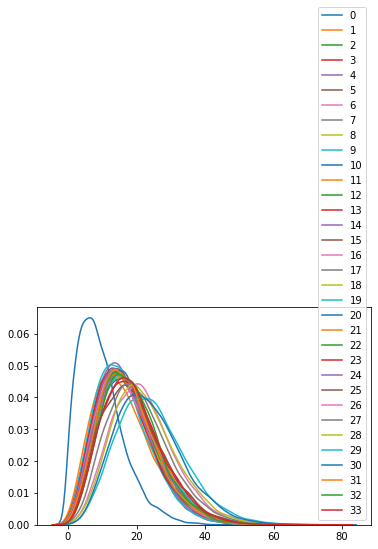

In [42]:
from seaborn import kdeplot
s = 10000
for i in range(int(len(equilibration2['grp_boosts'])/s)):
    
    kdeplot(equilibration2['grp_boosts'][i*s:(i+1)*s], label=i, alpha=1)
plt.legend()

Text(0.5, 1.0, 'Boost magnitude histogram\n(should be gaussian)')

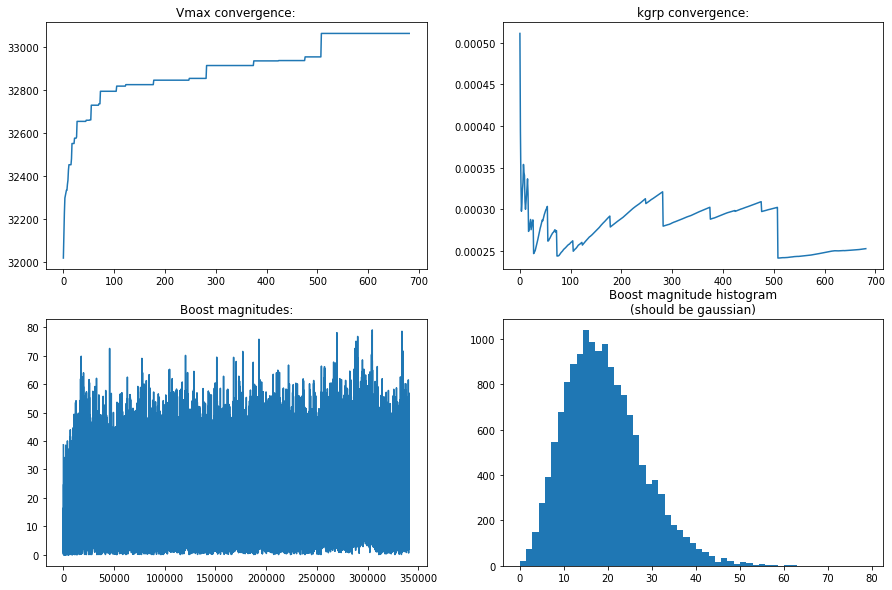

In [43]:
fig, ax = plt.subplots(2,2)
fig.set_figwidth(15)
fig.set_figheight(10)
ax[0,0].plot(gvmaxs)
ax[0,0].set_title('Vmax convergence:')

ax[0,1].plot(gks)
ax[0,1].set_title('kgrp convergence:')

ax[1,0].plot(equilibration2['grp_boosts'])
ax[1,0].set_title('Boost magnitudes:')


ax[1,1].hist(equilibration2['grp_boosts'][-15000:],bins=55)
ax[1,1].set_title('Boost magnitude histogram\n(should be gaussian)')

Text(0.5, 1.0, 'Boost magnitude histogram\n(should be gaussian)')

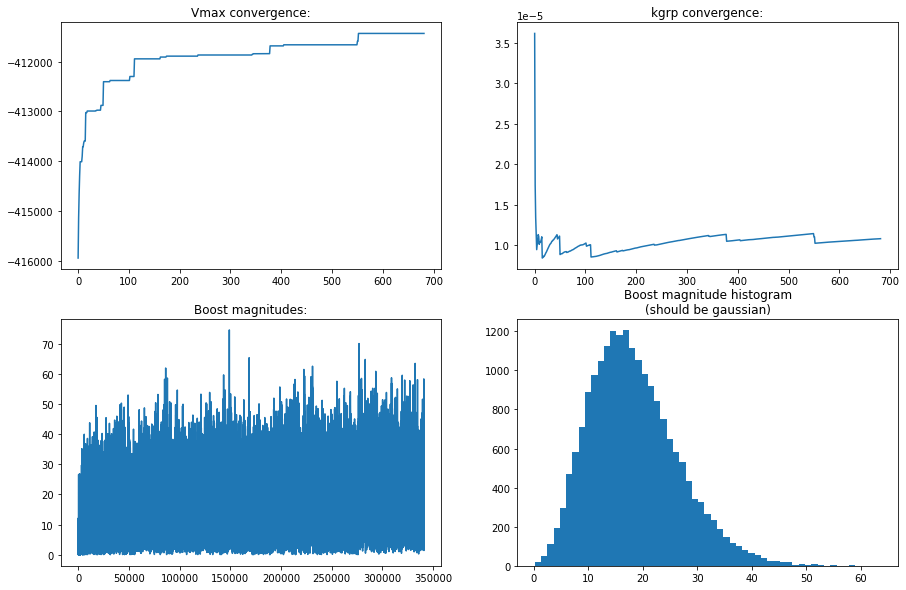

In [44]:
fig, ax = plt.subplots(2,2)
fig.set_figwidth(15)
fig.set_figheight(10)
ax[0,0].plot(vmaxs)
ax[0,0].set_title('Vmax convergence:')

ax[0,1].plot(ks)
ax[0,1].set_title('kgrp convergence:')

ax[1,0].plot(equilibration2['tot_boosts'])
ax[1,0].set_title('Boost magnitudes:')


ax[1,1].hist(equilibration2['tot_boosts'][-20000:],bins=55)
ax[1,1].set_title('Boost magnitude histogram\n(should be gaussian)')

# Add a trajectory reporter and do some production run:

In [45]:


sim.reporters.append(DCDReporter('gamd_traj.dcd', dcdstride))



In [47]:
sim.step(int(200*one_ns))

KeyboardInterrupt: 

# Simulate:

In [56]:
def calc_k(nrgs, threshold, kt=1):
    arr = np.array(nrgs)
    k = 0.2
    while np.std(arr - (arr - threshold)*(k)) > kt:
        k+=0.001
        #print(k,np.std(arr - (arr - threshold)*(k)))
    return k

In [57]:
Vmax, Vmin, Vavg, Vstd = get_statistics(tot_nrgs, 0)
E = Vavg
k = calc_k(tot_nrgs, np.mean(tot_nrgs), kt=10*SIGMA0)

#E,k = calc_parameters(Vmax, Vmin, Vavg, Vstd, sigma_0=SIGMA0*10)
sim.integrator.setEtot(E)
sim.integrator.setKtot(k)

Vmax, Vmin, Vavg, Vstd = get_statistics(grp_nrgs, 0)
E = Vavg
k = k = calc_k(grp_nrgs, np.mean(grp_nrgs), kt=10*SIGMA0)
#E,k = calc_parameters(Vmax, Vmin, Vavg, Vstd, sigma_0=SIGMA0*3)
sim.integrator.setEgrp(E)
sim.integrator.setKgrp(k)

In [58]:
production = dict()
production['grp_nrgs'] = list()
production['tot_nrgs'] = list()

production['grp_boosts'] = list()
production['tot_boosts'] = list()

def report(sim, prod):
    grp_nrg = sim.context.getState(getEnergy=True, groups={2}).getPotentialEnergy()/kilojoules_per_mole
    tot_nrg = sim.context.getState(getEnergy=True, groups={0}).getPotentialEnergy()/kilojoules_per_mole
        
    grp_boost = sim.integrator.getGrpBoost(grp_nrg)/kilojoule_per_mole
    tot_boost = sim.integrator.getTotBoost(tot_nrg)/kilojoule_per_mole
        
    prod['grp_boosts'].append(grp_boost)
    prod['tot_boosts'].append(tot_boost)
        
    prod['grp_nrgs'].append(grp_nrg)
    prod['tot_nrgs'].append(tot_nrg)
    

In [59]:
etot = list()
ktot = list()
egrp = list()
kgrp = list()

In [60]:
for _ in range(20):
    sim.step(500)
    report(sim, production)
    
    
for _ in tqdm.tqdm_notebook(range(200000)):
    report(sim, production)
    if _ % 30 == 0:
        nrgs = production['tot_nrgs']
        E = np.mean(nrgs[-100:])
        k = calc_k(nrgs, np.mean(nrgs[-100:]), kt=10*2.6)
        sim.integrator.setGlobalVariableByName('Etot', E)
        sim.integrator.setGlobalVariableByName('ktot', k)
        etot.append(E)
        ktot.append(k)
        
        nrgs = production['grp_nrgs']
        E = np.mean(nrgs[-100:])
        k = calc_k(nrgs, np.mean(nrgs[-100:]), kt=10*2.6)
        sim.integrator.setGlobalVariableByName('Egrp', E)
        sim.integrator.setGlobalVariableByName('kgrp', k)
        egrp.append(E)
        kgrp.append(k)
    
    sim.step(500)
    

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

KeyboardInterrupt: 

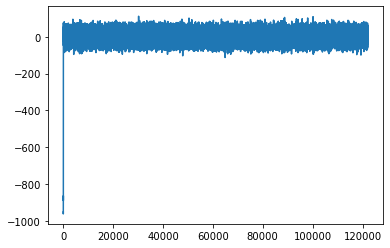

In [63]:
plt.plot(production['tot_boosts'])

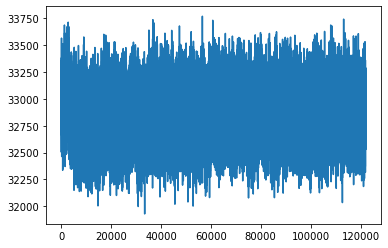

In [64]:
plt.plot(production['grp_nrgs'])

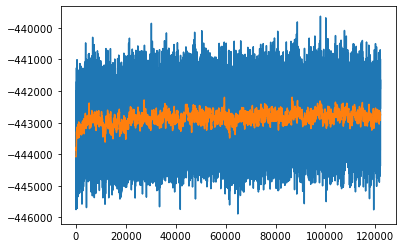

In [68]:
plt.plot(production['tot_nrgs'])
plt.plot(np.repeat(etot,30))

In [71]:
E = max(production['tot_nrgs'])
k = 0.2
1 - (E*k)/2


43964.12876032861

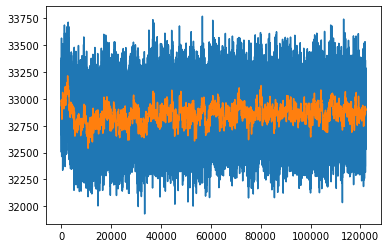

In [69]:
plt.plot(production['grp_nrgs'])
plt.plot(np.repeat(egrp,30))